In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import psycopg2
import sqlalchemy as sa
import datetime
from datetime import timedelta,datetime 
from dateutil.relativedelta import relativedelta
from sklearn.cluster import KMeans
import warnings 

from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import kstest, norm  ,shapiro 

# import sys
# import os
# sys.path.append(os.path.abspath("../"))
# #from recsys import *
# #from generic_preprocessing import *
# from IPython.display import HTML

### Check normal distributed data 

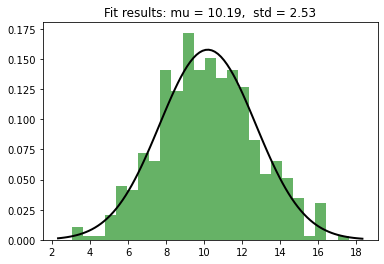

In [24]:



# Generate some data for this demonstration.
data = norm.rvs(10.0, 2.5, size=500)

# Fit a normal distribution to the data:
mu, std = norm.fit(data)

# Plot the histogram.
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

## our  data

In [2]:
df=pd.read_csv('your file .csv')

In [ ]:
#df.head()

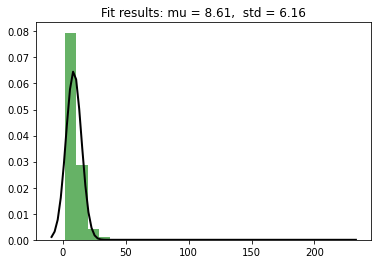

In [27]:
# Fit a normal distribution to the data:
mu_df, std_df = norm.fit(df['trx'])

# Plot the histogram.
plt.hist(df['trx'], bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu_df, std_df)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu_df, std_df)
plt.title(title)

plt.show()

### Kolmogorov Smirnov test

In [35]:

def Kolmogorov_test(df):
    ks_statistic, p_value = kstest(df, 'norm')
    print(ks_statistic, p_value)
    if p_value <0.05:
        print("reject H0 that distribution is normal") #not normal
    else:
        print("can't reject H0 that distribution is normal") # normal

## Lilliefors test

In [43]:
#If the P-Value of the Lilliefors Test is larger than 0.05, we assume a normal distribution
def Lilliefors_test(df):
    ksstat,p=lilliefors(df)

    if p <0.05:
        print("reject H0 that distribution is normal") #not normal
    else:
        print("can't reject H0 that distribution is normal") # normal

## Shapiro Wilk test

In [52]:
#Shapiro Wilk normal distribution test
#If the P-Value of the Shapiro Wilk Test is larger than 0.05, we assume a normal distribution p-value may not be accurate for N > 5000
def shapiro_test(df):
    stat, p=shapiro(df)
    if p <0.05:
            print("reject H0 that distribution is normal") #not normal
    else:
        print("can't reject H0 that distribution is normal") # normal


In [57]:
Kolmogorov_test(df.trx)

0.9772498680518208 0.0
reject H0 that distribution is normal


In [58]:
Kolmogorov_test(data)

0.9988555540764671 0.0
reject H0 that distribution is normal


In [39]:
# !pip3 uninstall statsmodels --yes
# !pip3 install numpy scipy patsy pandas
# !pip3 install statsmodels

In [44]:
Lilliefors_test(df.trx)

reject H0 that distribution is normal


In [45]:
Lilliefors_test(data)

can't reject H0 that distribution is normal


In [54]:
shapiro_test(df.trx)

reject H0 that distribution is normal


In [53]:
shapiro_test(data)

can't reject H0 that distribution is normal


# Sampling methods

1- Random Sampling

In [73]:
def random_sampling(df,population_count):
    sample_count=population_count*.1
    random_sample=df.sample(int(sample_count))
    return random_sample
    

2- systematic sampling

In [75]:
def systematic_sampling(df, step):
    indexes = np.arange(0, len(df), step=step)
    systematic_sample = df.iloc[indexes]
    return systematic_sample

3- satified sampling

In [88]:
def __smpl_size(population, size):
    
    if size is None:
        cochran_n = round(((1.96)**2 * 0.5 * 0.5)/ 0.02**2)
        n = round(cochran_n/(1+((cochran_n -1) /population)))
    elif size >= 0 and size < 1:
        n = round(population * size)
    elif size < 0:
        raise ValueError('Parameter "size" must be an integer or a proportion between 0 and 0.99.')
    elif size >= 1:
        n = size
    return n


In [89]:
def stratified_sample(df, strata, size=None, seed=None, keep_index= True):
    population = len(df)
    size = __smpl_size(population, size)
    tmp = df[strata]
    tmp['size'] = 1
    tmp_grpd = tmp.groupby(strata).count().reset_index()
    tmp_grpd['samp_size'] = round(size/population * tmp_grpd['size']).astype(int)
 
    first = True 
    for i in range(len(tmp_grpd)):
        # query generator for each iteration
        qry=''
        for s in range(len(strata)):
            stratum = strata[s]
            value = tmp_grpd.iloc[i][stratum]
            n = tmp_grpd.iloc[i]['samp_size']

            if type(value) == str:
                value = "'" + str(value) + "'"
            
            if s != len(strata)-1:
                qry = qry + stratum + ' == ' + str(value) +' & '
            else:
                qry = qry + stratum + ' == ' + str(value)
        
        # final dataframe
        if first:
            stratified_df = df.query(qry).sample(n=n, random_state=seed).reset_index(drop=(not keep_index))
            first = False
        else:
            tmp_df = df.query(qry).sample(n=n, random_state=seed).reset_index(drop=(not keep_index))
            stratified_df = stratified_df.append(tmp_df, ignore_index=True)
    
    return stratified_df


In [74]:
random_sample=random_sampling(df,df['customer_magic'].nunique())

In [84]:
systematic_sample=systematic_sampling(df,100)

In [100]:
Ssize=__smpl_size(df['customer_magic'].nunique(),df['customer_magic'].nunique()*.1)
starified_sampling=stratified_sample(df,['trx','max_date'],Ssize)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### t-test

In [28]:
from scipy import stats
#stats.ttest_rel(df.trx,random_sample.trx) #paired t-test 
stats.ttest_ind(df.trx,random_sample.trx, equal_var = False)#two-tailed test. If you want 
#to know if one group mean is greater or less than the other, use a left-tailed or right-tailed one-tailed test.


Ttest_indResult(statistic=-0.5389899630007632, pvalue=0.5899612132943937)

In [29]:
from numpy import mean
from numpy import std
print('data1: mean=%.3f stdv=%.3f' % (mean(df.trx), std(df.trx)))
print('data2: mean=%.3f stdv=%.3f' % (mean(random_sample.trx), std(random_sample.trx)))

data1: mean=8.607 stdv=6.163
data2: mean=8.683 stdv=5.805


### u-test

In [41]:
from scipy.stats import mannwhitneyu
def utest(df,sample):
    stat, p = mannwhitneyu(df,sample)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')

In [43]:
utest(df.trx, random_sample.trx)

Statistics=138988180.500, p=0.165
Same distribution (fail to reject H0)
